# Calcul des Modes Verticaux puis extraction harmonique

In [3]:
%load_ext memory_profiler
#%matplotlib widget
import matplotlib as mpl
from matplotlib import pyplot as plt
#from glob import glob
from pathlib import Path
import os

import numpy as np

import scipy.interpolate as itp
import xarray as xr
from xorca.lib import load_xorca_dataset
#import gsw
from xgcm import Grid

if True:
    from nemodez import Vmodes, load_vmodes

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [4]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client

/Users/romain/opt/anaconda3/envs/xorca/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60481 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:60482 Dashboard: http://127.0.0.1:60481/status,Cluster Workers: 4 Cores: 4 Memory: 5.59 GiB


In [5]:
data_path = Path("/Volumes/Calcul/eNATL60")

data_fname = "eNATL60NOE-BLBT02_y2010m01d01.1h_*_0-botm.nc"
grid_fname = ["mesh_*_eNATL60NOE_3.6.nc", "mask_eNATL60NOE_3.6.nc"]

data_files = list(data_path.glob(data_fname))
grid_files = sum([list(data_path.glob(fna)) for fna in grid_fname],[]) # trick to flatten: sum([list_of_list],[])

In [6]:
### Loading data from numerical run
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

ds_tot = ds_tot.isel(t=0)
ds_tot

dataset is 2.6 GB


<xarray.Dataset>
Dimensions:   (x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    vomecrty  (z_c, y_r, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vosaline  (z_c, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    votemper  (z_c, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vovecrtz  (z_l, y_c, x_c) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vozocrtx  (z_c, y_c, x_r) float32 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>

In [7]:
### Loading mean stratification profile
mean_file = data_path/"eNATL60NOE_mean_strat.nc"
ds_moy = xr.open_dataset(mean_file)
if "e3w" not in ds_moy:   
    ds_moy = ds_moy.assign_coords(e3w=ds_tot.e3w)
ds_moy

<xarray.Dataset>
Dimensions:   (x_c: 119, y_c: 137, z_c: 300, z_l: 300)
Coordinates: (12/13)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 130 131 132 133 134 135 136 137
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 112 113 114 115 116 117 118 119
    depth_c   (z_c) float64 ...
    llat_cc   (y_c, x_c) float32 ...
    llon_cc   (y_c, x_c) float32 ...
    ...        ...
    e2t       (y_c, x_c) float64 ...
    e3t       (z_c, y_c, x_c) float64 ...
    tmask     (z_c, y_c, x_c) int8 ...
    depth_l   (z_l) float64 ...
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
    e3w       (z_l, y_c, x_c) float64 ...
Data variables:
    vosaline  (z_c, y_c, x_c) float32 ...
    votemper  (z_c, y_c, x_c) float32 ...
    Nsqr      (z_l, y_c, x_c) float32 ...

In [8]:
### Define xgcm grids
# WARNINGS: for vertical level: weights only for T-lev on T, u and v grid, and for w-lev on T_points
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    #('X', 'Y'): [] # Areas TODO
}
ix, jy = slice(0,1), slice(0, 1)
sds = ds_tot.isel(x_c=ix, x_r=ix, y_c=jy, y_r=jy).chunk({"x_c":10, "y_c":10})
sdm = ds_moy.isel(x_c=ix, y_c=jy).chunk({"x_c":10, "y_c":10, "z_c":-1, "z_l":-1})
grid = Grid(sds, metrics=metrics, periodic=False)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   x_c --> right
  * right    x_r --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_r --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> left
  * left     z_l --> center

## Compute vertical modes

compute, store and load

In [9]:
vmods = Vmodes(sdm, grid, nmodes=10, free_surf=False, persist=True)
dm = vmods.ds
dm

<xarray.Dataset>
Dimensions:  (mode: 11, x_c: 1, y_c: 1, z_c: 300, z_l: 300)
Coordinates: (12/14)
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5
  * y_c      (y_c) int64 1
  * x_c      (x_c) int64 1
    llat_cc  (y_c, x_c) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    llon_cc  (y_c, x_c) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...       ...
    depth_l  (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    e3w      (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 1, 1), meta=np.ndarray>
    depth_c  (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    tmask    (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 1, 1), meta=np.ndarray>
    e3t      (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 1, 1), meta=np.ndarray>
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    Nsqr     (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 1, 1), meta=np.ndarray>
    c        (y_c, x_c, mode) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
    phi      (y_c, x_c, z_c, mode) float64 dask.array<chunksize=(1, 1, 300, 11), meta=np.ndarray>
    phiw     (y_c, x_c, z_l, mode) float64 dask.array<chunksize=(1, 1, 300, 11), meta=np.ndarray>
    norm     (y_c, x_c, mode) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>

In [10]:
### store modes and reload it
vmods.store("essai.zarr", mode="w")
del vmods
vmods = load_vmodes("essai.zarr")
vmods

Store vertical modes in /Users/romain/Desktop/ITideNATL/dev_notebooks/essai.zarr


Vmode object with dimensions ('mode', 'x_c', 'y_c', 'z_c', 'z_l')
  Number of modes = 10
  Corresponding Dataset in self.ds 
  Options / parameters:
g=9.81e+00, eig_sigma=1.00e-01, siz_sparse=3.00e+01
free_surf=False, corr_N=True

In [11]:
dm.c.isel(mode=0).values

array([[1.89812531e+08]])

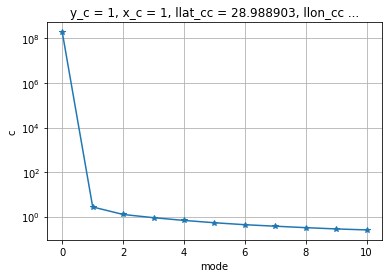

In [12]:
plt.figure()
dm.c.plot(marker="*", yscale="log")
plt.grid(True)

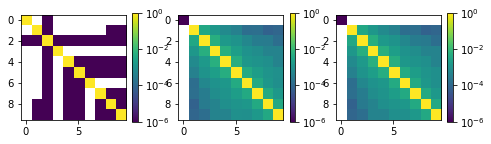

In [13]:
### check orthonormality
dm = dm.isel(x_c=0, y_c=0, mode=slice(10), missing_dims="ignore")

pnpm = (dm.phi*dm.phi.rename({"mode":"modm"})*dm.e3t).sum("z_c") / dm.norm.mean()
wnwm = dm.phiw/dm.c * (dm.phiw/dm.c).rename({"mode":"modm"})
wnwm_b = ( (wnwm*dm.Nsqr*dm.e3w).sum("z_l") + vmods.g*wnwm.isel(z_l=0) ) / dm.norm.mean()
wnwm_a = ( (grid.interp(wnwm*dm.Nsqr, "Z", boundary="fill", fill_value=0) * dm.e3t).sum("z_c") 
        + vmods.g * wnwm.isel(z_l=0) )/dm.norm.mean()

norm = mpl.colors.LogNorm(vmin=1e-6, vmax=1e0)
fig, axs = plt.subplots(1, 3, figsize=(8,2))
ax = axs[0]
hpc = ax.imshow(pnpm.values, norm=norm)
plt.colorbar(hpc, ax=ax)
ax = axs[1]
hpc = ax.imshow(wnwm_a.values, norm=norm)
plt.colorbar(hpc, ax=ax)
ax = axs[2]
hpc = ax.imshow(wnwm_b.values, norm=norm)
plt.colorbar(hpc, ax=ax)


(array(20.7113742), array(6.38295495e-35), array(20.52349637))

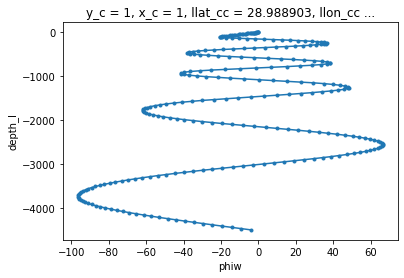

In [14]:
imod = -1

plt.figure()
dm.phiw.isel(mode=imod).plot(y="depth_l", marker=".")

I = (grid.interp(dm.phiw.isel(mode=imod)**2*dm.Nsqr, "Z", boundary="fill", fill_value=0) * dm.e3t).sum("z_c")
S = vmods.g*dm.phiw.isel(z_l=0,mode=imod)**2
res = (dm.c**2*dm.norm).isel(mode=imod)
I.values, S.values, res.values

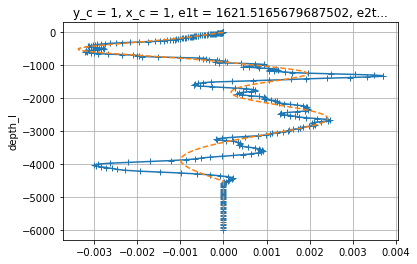

In [17]:
modamp = vmods.project_w(sds.vovecrtz)

plt.figure()
sds.vovecrtz.isel(x_c=0, y_c=0).plot(y="depth_l", marker="+")
vmods.reconstruct_w(modamp).assign_coords(depth_l=sds.depth_l).isel(x_c=0, y_c=0).plot(y="depth_l", linestyle="--")
plt.grid(True)

## Extraction harmonique 

bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.1 1.5
bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.0 1.5
bornes, T, eps, t0: 0.30000000000000004 2.7 2.0 0.1 1.5


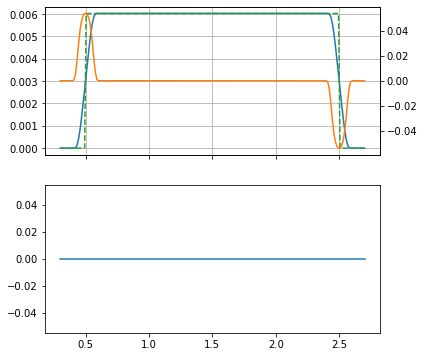

In [18]:
### define a window function

def planck_taper_ext(t, T=1., eps=.1, t0=0., normalized=True):
    """ planck taper window with transient centered at window length 
    quick and dirty implementation. Window is  centered
    planck taper with standard definition: transient centered at -T(.5-eps), T*(.5-eps). 
    extending time to T/(1-eps) make the interval between transient center equals T.
    return normalized window such that sum is 1 """
    print("bornes, T, eps, t0:", t.min(), t.max(), T, eps, t0)
    if eps>=.5:
        raise ValueError("need eps<.5. Passed value is {:.2f}".format(eps))
    t = (t-t0)/T*(1.-eps) # use coordinate mapping: stretching 
    t1, t4 = -.5, .5
    win = np.where((t>t1) * (t<t4), 1., 0.)
    if eps > 0.:
        t2 = (eps-.5)
        t3 = (.5-eps)
        z_t = np.where(t<0., (t2-t1)/(t-t1) + (t2-t1)/(t-t2), (t3-t4)/(t-t3) + (t3-t4)/(t-t4))
        win = np.where((t<t2) + (t>t3), win/(np.exp(z_t)+1.), win)

    if normalized and win.max()>0.:
        win /= win.sum()
        
    return win

### test it
Lwin, eps, t0 = 2., .1, 1.5
t_t = t0 + np.linspace(-Lwin*(.5+eps), Lwin*(.5+eps),200)
yy = planck_taper_ext(t_t, Lwin, eps, t0)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,6))
ax = axs[0]
ax.plot(t_t, yy)
ax.plot(t_t, planck_taper_ext(t_t, Lwin, 0., t0), linestyle="--", color="C2")
ax.grid(True)
bx = ax.twinx()
bx.plot(t_t, np.gradient(yy, t_t), color="C1")

ax = axs[1] # this must be 0
yy = planck_taper_ext(t_t, Lwin, eps, t0, normalized=False)
ax.plot(t_t, (yy>.5)-np.where( (t_t>t0-Lwin/2.) * (t_t<t0+Lwin/2.), 1., 0.) )


In [19]:
# """ HARMONIC EXTRACTION """
### Préparation dataset
#da = xr.DataArray(data = sig, dims =("time"), coords = {"time" : tt})
#da = dm.isel(x_c=0, y_c=0, mode=0, missing_dims="ignore")
da = xr.DataArray(data = dm.isel(x_c=0, y_c=0, mode=0, missing_dims="ignore").Nsqr, dims = ("z_l"), coords = {"z_l" : dm.isel(x_c=0, y_c=0, mode=0, missing_dims="ignore").z_l})


l : 2
bornes, T, eps, t0: <xarray.DataArray 'Nsqr' ()>
array(0., dtype=float32) <xarray.DataArray 'Nsqr' ()>
array(3.5194298e-05, dtype=float32) 1.2566370614359172 0.4 <xarray.DataArray 'z_l' ()>
array(1.)


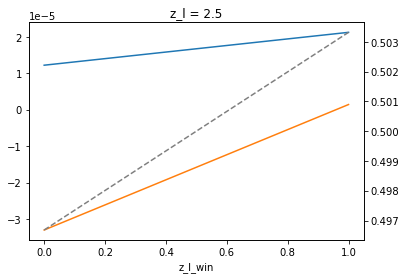

In [23]:
### Define periods and stuff
dz = 1
omega = 5
f = omega / 2./np.pi
eps_win = .4# relative length (in periods) of transient for time window
n_per = 1 # number of targeted periods / window
n_win = int(round( ((n_per+eps_win))/f/dz))
print("l :", n_win)

### harmonic extraction
# create rolling object and construt: window index is a new dim, "t_win"
da_rol = (da*xr.ufuncs.exp(-1.j*omega*da.z_l)).rolling(z_l=n_win, center=True).construct("z_l_win")
win = xr.DataArray(data=planck_taper_ext(da[:n_win], T=n_per/f, eps=eps_win, t0=da.z_l[:n_win].mean()), 
                   dims=("z_l_win"))
da_harmo_win = (da_rol*win).sum("z_l_win")

da_rol.isel(z_l=n_win).real.plot()
da_rol.isel(z_l=n_win).imag.plot()
bx = plt.gca().twinx()
win.plot(ax=bx, linestyle="--", color="grey")

In [24]:
dm.isel(x_c=0, y_c=0, mode=0, missing_dims="ignore").Nsqr

<xarray.DataArray 'Nsqr' (z_l: 300)>
dask.array<getitem, shape=(300,), dtype=float32, chunksize=(300,), chunktype=numpy.ndarray>
Coordinates:
  * z_l      (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 295.5 296.5 297.5 298.5 299.5
    y_c      int64 1
    x_c      int64 1
    llat_cc  float32 dask.array<chunksize=(), meta=np.ndarray>
    llon_cc  float32 dask.array<chunksize=(), meta=np.ndarray>
    e1t      float64 dask.array<chunksize=(), meta=np.ndarray>
    e2t      float64 dask.array<chunksize=(), meta=np.ndarray>
    depth_l  (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    e3w      (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    mode     int64 0

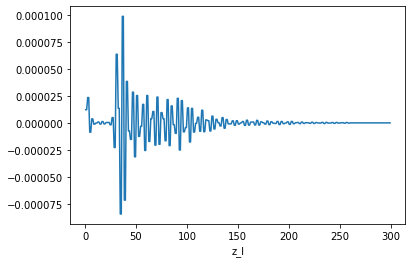

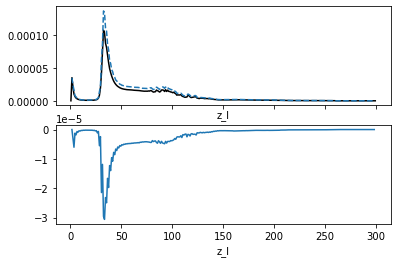

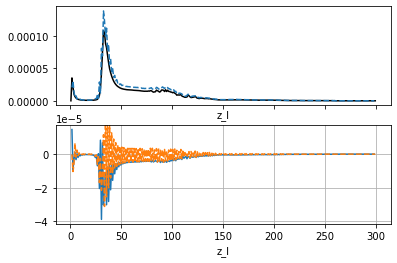

In [25]:
"""
Méthodes reconstruction:
    Méthode 1:
        Pour chaque fenêtre on multiplie la valeur par exp(j*omega*t) avec t vecteur temps réduit à la fenêtre
    Méthode 2:
        Interpolation linéaire entre chaque point 
        Rééchantillonage au temps de tps
        Multiplication en chaque point par exp(j*omega*t)
"""

# take harmonic with no windowing
da_harmo = (2*da*xr.ufuncs.exp(-1.j*omega*da.z_l)).coarsen(
                        z_l=n_win, boundary="trim", side="left").mean()

### Méthode 1
# une façon de procéder est d'utiliser interp1d avec method=nearest (un peu moche car commence par étendre le tableau des coefficient complexes)
# une autre façon est d'utiliser un groupby_bins sur le tableau de exp(1.j*omega*time). Pas fait ici
plt.figure()
da_harmo.interp(z_l=da.z_l, method="nearest", kwargs={"fill_value":"extrapolate"}).real.plot()

fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
da.plot(ax=ax, color="k")
reco = (da_harmo.interp(z_l=da.z_l, method="nearest")*xr.ufuncs.exp(1.j*omega*da.z_l)).real
reco.plot(ax=ax, linestyle="--")
ax = axs[1]
(da-reco).plot(ax=ax)

# method 2: interp
fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
da.plot(ax=ax, color="k")
reco = (da_harmo.interp(z_l=da.z_l, method="cubic")*xr.ufuncs.exp(1.j*omega*da.z_l)).real
reco.plot(ax=ax, linestyle="--")
ax = axs[1]
(da-reco).plot(ax=ax)

# also using harmonic extraction with windowing // emulate coarsening and re-interp
# it is a bit better except at the boundaries 
# (because I did not use a special treatment at boundaries, but this can be fixed easily)
limy = ax.get_ylim()
reci = (2*da_harmo_win.isel(z_l=slice(n_win//2,None,n_win)).interp(z_l=da.z_l, method="cubic")*xr.ufuncs.exp(1.j*omega*da.z_l)).real
(da-reci).plot(ax=ax, linestyle="--")
ax.set_ylim(limy)
ax.grid(True)